$$
\frac{\partial^2}{\partial x^2}u(x,t)
= \frac{1}{v^2}
\frac{\partial^2}{\partial t^2}u(x,t)
$$

$$
\frac{1}{\Delta x^2}
(u_{i+1,j} - 2 u_{i,j} + u_{i,j})
= 
\frac{1}{v^2\Delta t^2}
(u_{i,j+1} - 2 u_{i,j} + u_{i,j-1})
$$

$$
u_{i,j+1}
= 
2 u_{i,j-1}
- u_{i,j-1}
+  \left(\frac{v\Delta t}{\Delta x}\right)^2
(u_{i+1,j} - 2 u_{i,j} + u_{i,j})
$$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import numba
%matplotlib inline
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
N = 1024
L = 10.0
v = 1.0
dx = L / N
dt = dx / v

In [3]:
u1 = np.empty(N, np.float32)
u2 = np.empty_like(u1)
x = np.linspace(0, L, N)

In [4]:
# Pluck the string at point x0 with a gausian with width sigma
x0, sigma = 3.57, 0.5
u1[:] = np.exp(-(x-x0)**2/(2*sigma**2))
u2[:] = u1

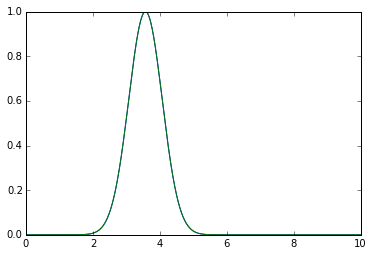

In [5]:
plt.plot(x, u1)
plt.plot(x, u2)

In [6]:
@numba.jit(nopython=True)
def propagate(nsteps, recinterval, u1, u2):
    nrec = nsteps // recinterval + 1
    tstore = np.empty(nrec)
    ustore = np.empty((nrec, N), np.float32)
    istore, t = 0, 0.0
    # Store the initial snapsho
    tstore[istore] = t
    for i in range(N):
        ustore[istore, i] = u1[i]
    a = v * dt / dx
    for istep in range(nsteps):
        # Decide which is the old and new wavefunction array
        if (istep % 2 == 0):
            uold, unew = u1, u2
        else:
            uold, unew = u2, u1
        # Update new wave function
        for i in range(1, N - 1):
            unew[i] = 2 * (1 - a) * uold[i] - unew[i] \
                    + a * (uold[i + 1] + uold[i - 1])
        t = t + dt
        # Store a snapshot every recinterval
        if ((istep + 1) % recinterval == 0):
            istore += 1
            tstore[istore] = t
            for i in range(N):
                ustore[istore, i] = unew[i]
    return tstore, ustore

In [7]:
NSTEPS, RECINT = 2000, 30
tstore, ustore = propagate(NSTEPS, RECINT, u1, u2)

In [8]:
def plot_wave(t):
    # First find the step
    istep = np.where(tstore >= t)[0][0]
    istep = min(istep, NSTEPS - 1)
    plt.plot(x, ustore[istep,:])
    plt.ylim(-1.2, 1.2)

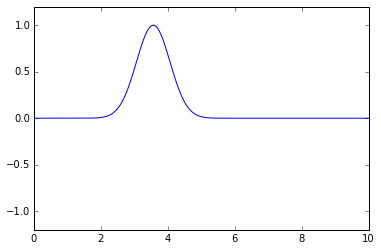

In [9]:
widgets.interact(plot_wave, t=widgets.FloatSliderWidget(min=0, max=tstore[-1], step=tstore[1], value=0));